The U-Net architecture is characterized by its U-shaped structure, which gives it its name. It consists of an ***encoding*** path and a ***decoding*** path.

U-Net’s strength comes from its use of ***skip connections***,which connect the encoding and decoding paths by merging features.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import random
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split


Define the repeated 2 3x3 convolutions followed by relu:

 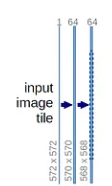

In [ ]:
class double_convolution(nn.Module):
  def __init__(self,in_channels,out_channels):
    super(double_convolution,self).__init__()
    self.convolution=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
        nn.ReLU(inplace=True)
    )
  def forward(self,x):
    return self.convolution(x)

Define the downsampling operation :

1- Double Convolution 3x3 + RELU

2- Maxpoooling 2x2

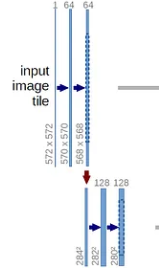

Note :
**conv** is the convolutioned tensor that is later on concatenated with an upsampled tensor with its own dimension

In [ ]:
class downsampling(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(downsampling, self).__init__()
    self.doubleconv=double_convolution(in_channels, out_channels)
    self.maxpool=nn.MaxPool2d(kernel_size=2, stride=2)
  def forward(self,x):
    conv=self.doubleconv(x)
    pool=self.maxpool(conv)
    return conv, pool

 Define the upsampling part: This corresponds to the right part of the figure (decoding path)

 This is done with a deconvolution (green arrow) followed by the double convolution.

 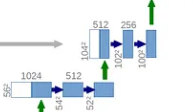

After upsampling, the result x1 is concatenated along the channel dimension with the corresponding feature map x2 from the encoder part of the U-Net.


In [ ]:
class upsampling(nn.Module):
  def __init__(self,in_channels,out_channels):
    super(upsampling,self).__init__()
    self.upsample=nn.ConvTranspose2d(in_channels,in_channels//2,kernel_size=2,stride=2)
    self.conv=double_convolution(in_channels,out_channels)
  def forward(self,x1,x2):
    x1=self.upsample(x1)

    x=torch.cat([x1,x2],1)

    return self.conv(x)



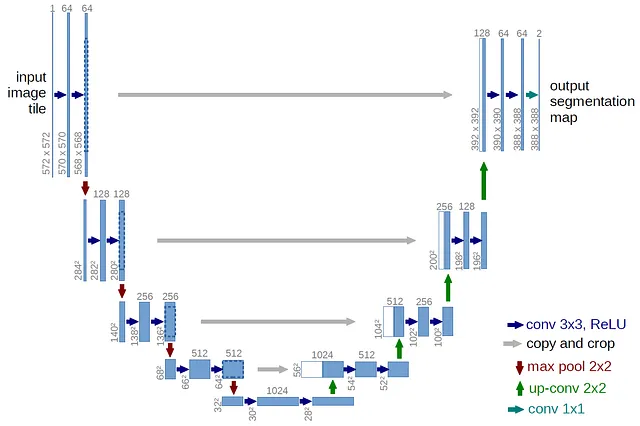

In [ ]:
class unet(nn.Module):

  def __init__(self,in_channels,classes, down_list):
    super().__init__()
    self.down1=downsampling(in_channels,down_list[0])
    self.down2=downsampling(down_list[0],down_list[1])
    self.down3=downsampling(down_list[1],down_list[2])
    self.down4=downsampling(down_list[2],down_list[3])


    self.bottleneck=double_convolution(down_list[3],down_list[4])


    self.up1=upsampling(down_list[4],down_list[3])
    self.up2=upsampling(down_list[3],down_list[2])
    self.up3=upsampling(down_list[2],down_list[1])
    self.up4=upsampling(down_list[1],down_list[0])


    self.final_layer=nn.Conv2d(down_list[0],classes,kernel_size=1)

  def forward(self,x):
    convolution_result1,pooling_result1=self.down1(x)
    convolution_result2,pooling_result2=self.down2(pooling_result1)
    convolution_result3,pooling_result3=self.down3(pooling_result2)
    convolution_result4,pooling_result4=self.down4(pooling_result3)

    bottleneck_result=self.bottleneck(pooling_result4)

    up_result1=self.up1(bottleneck_result,convolution_result4)
    up_result2=self.up2(up_result1,convolution_result3)
    up_result3=self.up3(up_result2,convolution_result2)
    up_result4=self.up4(up_result3,convolution_result1)

    return self.final_layer(up_result4)






Test the code with a dummy tensor of shape

(batch_size, in_channels, height, width)

In [ ]:
down_list = [64, 128, 256, 512, 1024]
input_tensor = torch.randn(1, 3, 256, 256)
model = unet(in_channels=3, classes=2,down_list=down_list)

output_tensor = model(input_tensor)
print(f"Output shape: {output_tensor.shape}")


Output shape: torch.Size([1, 2, 256, 256])


## Carvana Dataset

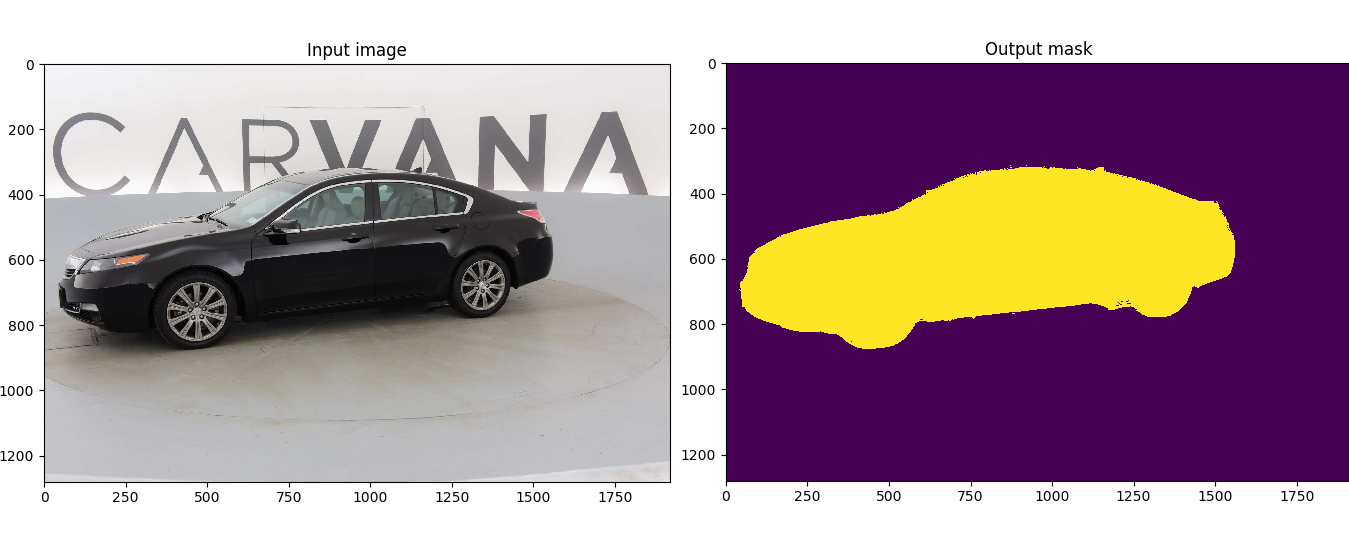

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zainabtarekk","key":"1c823275c10d6744fd6028b12b2b7216"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c carvana-image-masking-challenge

100% 24.4G/24.4G [14:12<00:00, 31.0MB/s]
100% 24.4G/24.4G [14:12<00:00, 30.7MB/s]


In [ ]:
!ls -l /content/carvana-image-masking-challenge.zip

-rw-r--r-- 1 root root 26214784235 Dec 12  2019 /content/carvana-image-masking-challenge.zip


In [ ]:
!unzip carvana-image-masking-challenge.zip -d /content/carvana_dataset

Archive:  carvana-image-masking-challenge.zip
  inflating: /content/carvana_dataset/29bb3ece3180_11.jpg  
  inflating: /content/carvana_dataset/metadata.csv.zip  
  inflating: /content/carvana_dataset/sample_submission.csv.zip  
  inflating: /content/carvana_dataset/test.zip  
  inflating: /content/carvana_dataset/test_hq.zip  
  inflating: /content/carvana_dataset/train.zip  
  inflating: /content/carvana_dataset/train_hq.zip  
  inflating: /content/carvana_dataset/train_masks.csv.zip  
  inflating: /content/carvana_dataset/train_masks.zip  


In [ ]:
!unzip carvana_dataset/train.zip -d /content/carvana_dataset
!unzip carvana_dataset/train_masks.zip -d /content/carvana_dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/carvana_dataset/train_masks/0789bed99cb8_09_mask.gif  
 extracting: /content/carvana_dataset/train_masks/0789bed99cb8_10_mask.gif  
 extracting: /content/carvana_dataset/train_masks/0789bed99cb8_11_mask.gif  
 extracting: /content/carvana_dataset/train_masks/0789bed99cb8_12_mask.gif  
  inflating: /content/carvana_dataset/train_masks/0789bed99cb8_13_mask.gif  
  inflating: /content/carvana_dataset/train_masks/0789bed99cb8_14_mask.gif  
  inflating: /content/carvana_dataset/train_masks/0789bed99cb8_15_mask.gif  
  inflating: /content/carvana_dataset/train_masks/0789bed99cb8_16_mask.gif  
 extracting: /content/carvana_dataset/train_masks/0795e132d090_01_mask.gif  
 extracting: /content/carvana_dataset/train_masks/0795e132d090_02_mask.gif  
 extracting: /content/carvana_dataset/train_masks/0795e132d090_03_mask.gif  
 extracting: /content/carvana_dataset/train_masks/0795e132d090_04_mask.gif  
 extracting: /content/car

In [ ]:
train_images_path = '/content/carvana_dataset/train'
train_masks_path = '/content/carvana_dataset/train_masks'

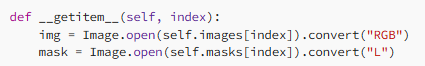

In [ ]:
class custom_dataset(Dataset):
  def __init__(self, images_path, masks_path):
    self.images_path = train_images_path
    self.masks_path =train_masks_path
    self.transform = transforms.Compose([
                                         transforms.Resize((512,512)),
                                         transforms.ToTensor()
    ])
    self.images = os.listdir(images_path)
    self.masks = os.listdir(masks_path)
    self.length = len(self.images)

  def __len__(self):
    return self.length

  def __getitem__(self, index):
    image = Image.open(self.images_path + "/" + self.images[index]).convert('RGB')
    mask = Image.open(self.masks_path + "/" + self.masks[index]).convert('L')
    image = self.transform(image)
    mask = self.transform(mask)


    return image, mask.squeeze(0).type(torch.LongTensor)




In [ ]:
train_dataset=custom_dataset(train_images_path, train_masks_path)
size=len(train_dataset)
print(size)

5088


In [ ]:
#since data is big , I will just use 20% of it now
train_dataset, test_dataset = random_split(train_dataset, [0.1,0.9])


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cpu


In [ ]:
down_list=[32,64,128,256,512]

In [ ]:
print(down_list)

[32, 64, 128, 256, 512]


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
model=unet(in_channels=3,classes=2,down_list=down_list).to(device) #1 class :car
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
loss_fn = nn.CrossEntropyLoss() #loss_fn??

In [ ]:
from tqdm.autonotebook import tqdm
train_losses=[]
def train(model, train_dataloader, optimizer, loss_fn,epochs):
  model.train()
  train_loss=0
  for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch+1}\n-------------------------------")

    size = len(train_dataloader.dataset)
    for batch, (X, y) in enumerate(train_dataloader):
      print("entered 1")
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      print("entered 2")



      loss = loss_fn(y_pred, y)
      optimizer.zero_grad()
      loss.backward()
      train_loss+=loss.item()
      optimizer.step()
    final_loss=train_loss/batch
    train_losses.append(final_loss)

  print(f"Training Loss EPOCH {epoch + 1}: {final_loss:}")
